In [1]:
# Just so that you don't have to restart the notebook with every change.
%load_ext autoreload
%autoreload 2 

In [2]:
import os
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import torch
from captum.attr import DeepLift, IntegratedGradients, NoiseTunnel, Occlusion, Saliency
from captum.attr import visualization as viz
from common import utils
from ultralytics import YOLO

plt.style.use(["science", "ieee", "no-latex", "std-colors"])

# Useful constants
CURRENT_DIR = os.getcwd()
IMAGES_DIR = os.path.join(CURRENT_DIR, "images")
VIDEOS_DIR = os.path.join(CURRENT_DIR, "videos")
CHORD_CLASSIFIER_MODEL_DIR = os.path.join(CURRENT_DIR, "chord-classifier-model")
FRETBOARD_RECOGNIZER_MODEL_DIR = os.path.join(CURRENT_DIR, "fretboard-recognizer-model")

# chord_clf_model_path = utils.find_files(CHORD_CLASSIFIER_MODEL_DIR, [".safetensors", ".pt"])
# chord_clf_config_path = utils.find_files(CHORD_CLASSIFIER_MODEL_DIR, [".json"])
chord_clf_model_path = os.path.join(CHORD_CLASSIFIER_MODEL_DIR, "model_dinov2_large.safetensors")
chord_clf_config_path = os.path.join(CHORD_CLASSIFIER_MODEL_DIR, "config_dinov2_large.json")
fretboard_rec_model_path = utils.find_files(FRETBOARD_RECOGNIZER_MODEL_DIR, [".safetensors", ".pt"])
fretboard_rec_config_path = utils.find_files(FRETBOARD_RECOGNIZER_MODEL_DIR, [".json"])

utils.ensure_files_exist(
    chord_clf_model_path,
    fretboard_rec_model_path,
    chord_clf_config_path,
    fretboard_rec_config_path,
    names=[
        "Chord Classifier model",
        "Fretboard Recognizer model",
        "Chord Classifier config",
        "Fretboard Recognizer config",
    ],
)

/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Chord Classifier model found at /home/camilo/Repositorios/hlcv/Project/src/video-to-chords-pipeline/chord-classifier-model/model_dinov2_large.safetensors
Fretboard Recognizer model found at /home/camilo/Repositorios/hlcv/Project/src/video-to-chords-pipeline/fretboard-recognizer-model/yolov9c_trained_with_head.pt
Chord Classifier config found at /home/camilo/Repositorios/hlcv/Project/src/video-to-chords-pipeline/chord-classifier-model/config_dinov2_large.json
Fretboard Recognizer config not found


Folder structure has to look like the following. Inside `chord-classifier-model` folder, there should be the `config.json` file and the `model.safetensors` file. On the other hand, the `fretboard-recognizer-model` should have a `.pt` file.

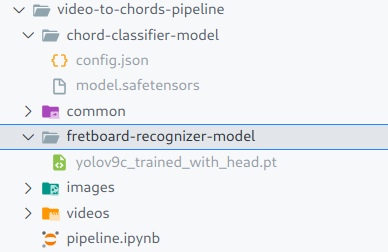

The `ultralytics` package that must be installed is (because `ConcatHead` does not exist in the normal package):

```bash
git clone https://github.com/CamiloMartinezM/ultralytics.git
cd ultralytics
pip install -e .

In [3]:
# Load Chord Classifier model
chord_clf_model = utils.load_model(chord_clf_model_path, config_path=chord_clf_config_path)

# Load Fretboard Recognizer model
fretboard_rec_model = utils.load_model(fretboard_rec_model_path, config_path=fretboard_rec_config_path, custom_class=YOLO)

print("Models loaded successfully.")

Models loaded successfully.


In [4]:
IMAGES = utils.find_files(IMAGES_DIR, [".jpg", ".jpeg", ".png"], find_all=True)
print(f"Found {len(IMAGES)} images for testing:")
for img in IMAGES:
    print(f"\t{img}")

Found 3 images for testing:
	/home/camilo/Repositorios/hlcv/Project/src/video-to-chords-pipeline/images/test-fretboard-2.jpg
	/home/camilo/Repositorios/hlcv/Project/src/video-to-chords-pipeline/images/test-fretboard-3.jpg
	/home/camilo/Repositorios/hlcv/Project/src/video-to-chords-pipeline/images/test-fretboard.jpg


In [5]:
test_image = utils.load_image_to_numpy(IMAGES[2])


0: 384x640 1 person, 1 fretboard, 42.1ms
Speed: 2.0ms preprocess, 42.1ms inference, 96.0ms postprocess per image at shape (1, 3, 384, 640)


/home/camilo/Repositorios/hlcv/Project/src/video-to-chords-pipeline/common/utils.py:467: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


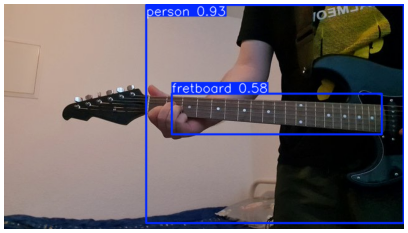

In [6]:
utils.show_model_output([fretboard_rec_model.predict(test_image)[0].plot()])


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 255.0. Dividing input by 255.


0: 640x640 1 person, 2 fretboards, 14.9ms
Speed: 0.7ms preprocess, 14.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


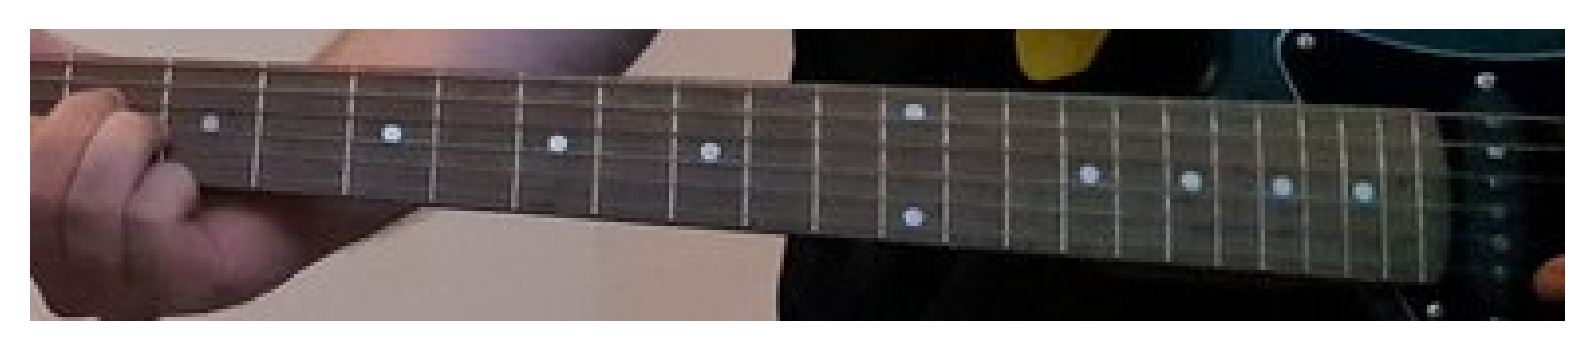

In [7]:
extracted_fretboard = utils.extract_box_object(
    test_image, fretboard_rec_model, class_name="fretboard", conf=0.25, expand_percent=15
)
if extracted_fretboard is not None:
    import matplotlib.pyplot as plt

    plt.imshow(extracted_fretboard)
    plt.axis("off")
else:
    print("Failed to extract the object.")

In [8]:
predicted_chord = utils.predict_chord(chord_clf_model, extracted_fretboard)
print(f"Predicted chord: {predicted_chord}")

Predicted chord: B


In [9]:
label2id = utils.invert_dict(chord_clf_model.config.id2label)

In [10]:
wrapped_model = utils.ClassificationModelWrapper(chord_clf_model).to("cuda")

In [11]:
input_tensor = utils.HWC_to_CHW(extracted_fretboard, add_batch_dim=True) # test_image or extracted_fretboard
input_tensor.requires_grad = True

strides = (3, 8, 8)
sliding_window_shapes=(3, 30, 30)

EXPECTED_CHORD = "B"

input_tensor = input_tensor.to("cuda")
print("Input tensor:", input_tensor.shape)
print("It should be classified as: ", EXPECTED_CHORD)

Input tensor: torch.Size([1, 3, 74, 389])
It should be classified as:  B


In [12]:
utils.clean_cache()

# Wrap your model
occlusion = Occlusion(wrapped_model)

attributions_occ = occlusion.attribute(
    input_tensor,
    strides=strides,
    target=label2id[EXPECTED_CHORD],
    sliding_window_shapes=sliding_window_shapes,
    baselines=0,
)

fig, _ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    input_tensor.squeeze().cpu().detach().numpy().transpose(1, 2, 0),
    methods=["blended_heat_map"],
    signs=["positive"],
    fig_size=(10, 20),
    use_pyplot=False,
    show_colorbar=True,
    cmap="Reds",
    outlier_perc=2,
    alpha_overlay=0.8,
)

fig.savefig(os.path.join(IMAGES_DIR, "occlusion_trained.pdf"), bbox_inches="tight", format="pdf", dpi=600)

untrained_dinov2 = utils.initialize_untrained_dinov2(chord_clf_model.config)
untrained_wrapped_model = utils.ClassificationModelWrapper(untrained_dinov2).to("cuda")

occlusion = Occlusion(untrained_wrapped_model)

attributions_occ = occlusion.attribute(
    input_tensor,
    strides=strides,
    target=label2id[EXPECTED_CHORD],
    sliding_window_shapes=sliding_window_shapes,
    baselines=0,
)

fig, _ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    input_tensor.squeeze().cpu().detach().numpy().transpose(1, 2, 0),
    methods=["blended_heat_map"],
    signs=["positive"],
    fig_size=(10, 20),
    use_pyplot=False,
    show_colorbar=False,
    cmap="Reds",
    outlier_perc=2,
    alpha_overlay=0.8,
)

fig.savefig(
    os.path.join(IMAGES_DIR, "occlusion_untrained.pdf"), bbox_inches="tight", format="pdf", dpi=600, pad_inches=0.225
)

plt.show()
plt.close(fig)

Freeing GPU Memory
Free: 6222 MB	Total: 7843 MB
